## RUL prediction using 1D CNN

In this notebook, we will use 1D CNN to predict RUL of NASA's turbofan engine dataset FD001. We will show the implementation without going into the theory of CNN.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers,models 
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


In [4]:
print("Tensorflow Version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow Version:  2.11.0
Numpy version:  1.23.4
Pandas version:  1.5.1
Scikit-learn version:  1.1.3


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [6]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [7]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In the following cell, we will apply `MinMaxScaling` to the full trianing dataset.

In [12]:
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]
train_data=pd.read_csv("../data/train_FD001.txt", sep= "\s+", header = None,names=columns)   
test_data =pd.read_csv("../data/test_FD001.txt", sep= "\s+", header = None,names=columns) 
true_rul = pd.read_csv("../data/RUL_FD001.txt", sep= "\s+", header = None) 

window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped =['id','op1','op2','op3', 'sensor1', 'sensor5', 'sensor6','sensor7','sensor10',
                 'sensor16', 'sensor18', 'sensor19']

train_data_first_column = train_data['id']
test_data_first_column = test_data['id']

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))

train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

/tmp/ipykernel_667/2183690729.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
/tmp/ipykernel_667/2183690729.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


/tmp/ipykernel_667/3567948236.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
/tmp/ipykernel_667/2183690729.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

In [13]:
processed_train_data.shape

(17731, 30, 14)

# **Pipeline**

In [51]:


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer









def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
 
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

#applying every things 
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]
train_data =pd.read_csv("/content/drive/MyDrive/Project/data/train_FD001.txt", sep= "\s+", header = None,names=columns) 
test_data =pd.read_csv("/content/drive/MyDrive/Project/data/test_FD001.txt", sep= "\s+", header = None,names=columns) 
true_rul = pd.read_csv("/content/drive/MyDrive/Project/data/RUL_FD001.txt", sep= "\s+", header = None) 

window_length = 30
shift = 1
early_rul = 125            


#
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped =['id','op1','op2','op3', 'sensor1', 'sensor5', 'sensor6','sensor7','sensor10',
                 'sensor16', 'sensor18', 'sensor19']


test_data_first_column = test_data['id']

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))

train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))


test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])


num_test_machines = len(test_data[0].unique())



def process_test_data_for_multiple_engines(test_data, num_test_machines, window_length, shift, num_test_windows, true_rul):
    processed_test_data = []
    num_test_windows_list = []
    
    for i in np.arange(1, num_test_machines + 1):
        temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

        # Verify if data of given window length can be extracted from test data
        if (len(temp_test_data) < window_length):
            print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
            raise AssertionError("Window length is larger than number of data points for some engines. "
                                 "Try decreasing window length.")

        # Prepare test data
        test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                                 num_test_windows = num_test_windows)

        processed_test_data.append(test_data_for_an_engine)
        num_test_windows_list.append(num_windows)

    processed_test_data = np.concatenate(processed_test_data)
    true_rul = true_rul[0].values
    
    return processed_test_data, true_rul, num_test_windows_list



    data_preprocessing = Pipeline([
    
    ('drop_columns', pd.DataFrame(data=test_data.drop(columns=columns_to_be_dropped))),
    ('scaler', MinMaxScaler(feature_range=(-1,1))),
    ('process_test_data', process_test_data_for_multiple_engines(test_data, window_length, shift, num_test_windows))
])
    model_pipeline = Pipeline([
    ('flatten_layer', flatten_layer_model),
    ('regressor', best_reg_model)
])
    clf=Pipline([
        ("data_preprocessing",data_preprocessing),
        ("model_pipeline",model_pipeline)

    ])
        
   clf.fit(Train,ytrain)


   y_pred_class= clf.predict(test_data)

IndentationError: ignored

## Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [14]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


## 1D CNN model

In [15]:
def create_compiled_model():
    model = Sequential([
        layers.Conv1D(256, 7, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(96, 7, activation = "relu"),
        layers.Conv1D(32, 7, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Flatten(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

We will use a learning rate scheduler that will decrease the learning rate after 10 epochs.

In [16]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

In [17]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [18]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 30,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)

2023-02-01 13:42:56.779104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-01 13:42:56.781104: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-01 13:42:56.781522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-SJ1O7ES7): /proc/driver/nvidia/version does not exist
2023-02-01 13:42:56.788877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
222/222 - 6s - loss: 812.8723 - val_loss: 337.4710 - lr: 0.0010 - 6s/epoch - 25ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/30
222/222 - 4s - loss: 316.1394 - val_loss: 308.4463 - lr: 0.0010 - 4s/epoch - 17ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/30
222/222 - 4s - loss: 280.5269 - val_loss: 255.2948 - lr: 0.0010 - 4s/epoch - 17ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/30
222/222 - 4s - loss: 240.1245 - val_loss: 231.0520 - lr: 0.0010 - 4s/epoch - 19ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/30
222/222 - 4s - loss: 231.4900 - val_loss: 249.7929 - lr: 0.0010 - 4s/epoch - 17ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/30
222/222 - 4s - loss: 220.8468 - val_loss: 215.2047 - lr: 0.0010 - 4s/epoch - 17ms/step

Epoch 7: LearningRateSchedu

Why did we run the model only for 30 epochs, even though the validation loss seems to be decreasing? Well, while training this model for more epochs, we previously observed that it is possible to decrease the validation loss to a very small number. But in that case, our actual test loss is not that great. This is because our model is overfitting the validation dataset. So to get a good test performance, we should stop our training at an intermediate value of the validation loss. We chose 20 epochs as that gives a good enough test error.

In [19]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 0s 6ms/step
RMSE:  17.252895919180233


### Save the model

In [10]:
tf.keras.models.save_model(model, "FD001_1D_CNN_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

NameError: ignored

We will now compute the RMSE by taking only last example of each engine.

In [22]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  17.369808849470804


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where, 

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [23]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [24]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  504.9154209841339


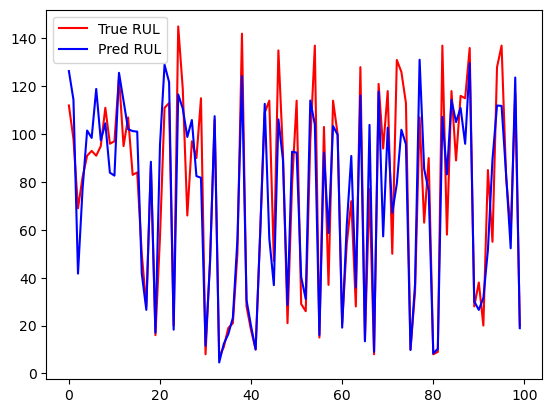

In [25]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

It is very likely that readers may get sligtly different results while running this notebook on their system. This happens because of the nondeterministic nature of some deep learning operations and dependence of libraries like `Tensorflow` on computer architecture. Therefore, to make our results reproducible, we also share saved models of all our notebooks. All saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/saved_models/cmapss). A notebook describing the procedure to use the saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_using_saved_model_deep_learning.ipynb). As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open). 

CNN2

In [53]:
cnn2=models.Sequential([
    #layers.Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])),
    layers.Conv1D(filters=32,kernel_size=3,activation='relu', input_shape=(window_length, processed_train_data.shape[2])),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(filters=32,kernel_size=3,activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(filters=32,kernel_size=3,activation='relu'),
    layers.MaxPooling1D(2),
    
     layers.Flatten(),
     # dense
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation="linear")])
    
cnn2.compile(optimizer='adam',loss='mean_squared_error')   

In [54]:
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 28, 32)            1376      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 12, 32)            3104      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 4, 32)             3104      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 32)           

In [55]:
history2 = cnn2.fit(processed_train_data, processed_train_targets,
                    validation_data=(processed_val_data, processed_val_targets),
                    epochs=30,
                   batch_size=32)


Epoch 1/30
444/444 [==============================] - 4s 7ms/step - loss: 947.4249 - val_loss: 336.4026
Epoch 2/30
444/444 [==============================] - 3s 6ms/step - loss: 293.1439 - val_loss: 251.9537
Epoch 3/30
444/444 [==============================] - 3s 7ms/step - loss: 242.7506 - val_loss: 229.9311
Epoch 4/30
444/444 [==============================] - 3s 7ms/step - loss: 223.4310 - val_loss: 243.8540
Epoch 5/30
444/444 [==============================] - 3s 6ms/step - loss: 213.4959 - val_loss: 220.5168
Epoch 6/30
444/444 [==============================] - 3s 6ms/step - loss: 198.3341 - val_loss: 237.5257
Epoch 7/30
444/444 [==============================] - 3s 6ms/step - loss: 188.5126 - val_loss: 238.6486
Epoch 8/30
444/444 [==============================] - 3s 6ms/step - loss: 184.1386 - val_loss: 224.8402
Epoch 9/30
444/444 [==============================] - 3s 6ms/step - loss: 179.2453 - val_loss: 191.2244
Epoch 10/30
444/444 [==============================] - 3s 6ms/st

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline([
    
    ('cnn2',cnn2)
])

# Define the hyperparameters and possible values
param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [3, 5, 7],
    'pool_size': [2, 3]
}

# Create the grid search object
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the pipeline to the training data
grid.fit(processed_train_data,processed_train_targets)

# Print the best parameters and best score
print("Best parameters: ", grid.best_params_)
print("Best MSE: ", grid.best_score_)

ValueError: ignored

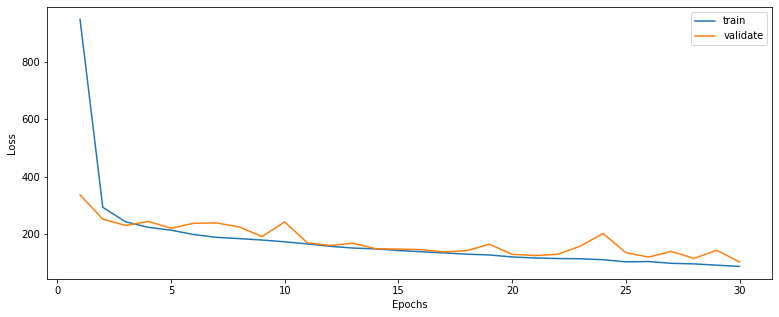

In [56]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history2)

In [57]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [58]:
rul_pred = cnn2.predict(processed_test_data)

16/16 [==============================] - 0s 4ms/step


In [59]:
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine,weights=np.repeat(1/num_windows, num_windows),axis=0)
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  15.229597950291504


In [60]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  15.14816552583477


In [61]:

evaluate(true_rul, mean_pred_for_each_engine)


test set RMSE:15.229597950291504, R2:0.8656872217059567


In [92]:
flatten_layer_model = tf.keras.Model(inputs=cnn2.input,
                                     outputs=cnn2.get_layer("flatten_1").output)
flatten_layer_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3_input (InputLayer)  [(None, 30, 14)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 28, 32)            1376      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 12, 32)            3104      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 4, 32)             3104

In [86]:
flatten_layer_model.compile(optimizer='adam',loss='mean_squared_error')  

In [90]:
flatten_layer_model.fit(processed_train_data, processed_train_targets)

TypeError: ignored

In [93]:
hope_test = flatten_layer_model.predict(processed_test_data)

KeyError: ignored

In [117]:
hope_test.shape

(497, 64)

In [64]:
hope_train = flatten_layer_model.predict(processed_train_data)

444/444 [==============================] - 1s 3ms/step


In [65]:
array = processed_train_targets.reshape(-1,1)

In [66]:
best_reg_model =SVR()
best_reg_model.fit(hope_train,array)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [67]:
import joblib


# save the model to disk
filename = 'SVR_model.sav'
joblib.dump(best_reg_model, filename)


['SVR_model.sav']

In [68]:
y_pred =best_reg_model.predict(hope_train)
#evaluate(label_array, y_pred, 'train')

#y_hat_test =best_reg_model.predict(featuers_flat_test)
#evaluate(y_test, y_hat_test)

In [69]:
evaluate(processed_train_targets, y_pred, 'train')

train set RMSE:10.132629360080916, R2:0.9412477068729744


In [78]:
y_pred_test =best_reg_model.predict(hope_test)

In [79]:
preds_for_each_engine = np.split(y_pred_test, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine,weights=np.repeat(1/num_windows, num_windows),axis=0)
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  16.226364590150027


In [80]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  15.794246619958141


In [32]:
evaluate(true_rul,mean_pred_for_each_engine, "test")

test set RMSE:16.241519554026567, R2:0.847245583902903


In [84]:
import joblib


# save the model to disk
filename = 'flatten_layer_model.sav'
joblib.dump(flatten_layer_model, filename)




['flatten_layer_model.sav']

In [82]:
import joblib


# save the model to disk
filename = 'SVR_model.sav'
joblib.dump(best_reg_model, filename)

['SVR_model.sav']

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer









def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
 
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

#applying every things 
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]
train_data =pd.read_csv("/content/drive/MyDrive/Project/data/train_FD001.txt", sep= "\s+", header = None,names=columns) 
test_data =pd.read_csv("/content/drive/MyDrive/Project/data/test_FD001.txt", sep= "\s+", header = None,names=columns) 
true_rul = pd.read_csv("/content/drive/MyDrive/Project/data/RUL_FD001.txt", sep= "\s+", header = None) 

window_length = 30
shift = 1
early_rul = 125            


#
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped =['id','op1','op2','op3', 'sensor1', 'sensor5', 'sensor6','sensor7','sensor10',
                 'sensor16', 'sensor18', 'sensor19']


test_data_first_column = test_data['id']

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))

train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))


test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])


num_test_machines = len(test_data[0].unique())



def process_test_data_for_multiple_engines(test_data, num_test_machines, window_length, shift, num_test_windows, true_rul):
    processed_test_data = []
    num_test_windows_list = []
    
    for i in np.arange(1, num_test_machines + 1):
        temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

        # Verify if data of given window length can be extracted from test data
        if (len(temp_test_data) < window_length):
            print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
            raise AssertionError("Window length is larger than number of data points for some engines. "
                                 "Try decreasing window length.")

        # Prepare test data
        test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                                 num_test_windows = num_test_windows)

        processed_test_data.append(test_data_for_an_engine)
        num_test_windows_list.append(num_windows)

    processed_test_data = np.concatenate(processed_test_data)
    true_rul = true_rul[0].values
    
    return processed_test_data, true_rul, num_test_windows_list

# load trained models 
loaded_model_SVR = joblib.load('SVR_model.sav')
loaded_model_CNN = joblib.load('flatten_layer_model.sav')

data_preprocessing = Pipeline([
    
    
    ('process_test_data', process_test_data_for_multiple_engines(test_data, num_test_machines, window_length, shift, num_test_windows, true_rul))
])
model_pipeline = Pipeline([
    ('flatten_layer',loaded_model_CNN),
    ('regressor',loaded_model_SVR)
])
clf=Pipeline([
        ("data_preprocessing",data_preprocessing),
        ("model_pipeline",model_pipeline)

    ])
        


y_pred_class= clf.predict()

<ipython-input-83-75cafc97d59d>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
<ipython-input-83-75cafc97d59d>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

TypeError: ignored

In [139]:
cnn3=models.Sequential([
    #layers.Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])),
    layers.Conv1D(filters=32,kernel_size=3,activation='relu', input_shape=(window_length, processed_train_data.shape[2])),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(filters=32,kernel_size=3,activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(filters=32,kernel_size=3,activation='relu'),
    layers.MaxPooling1D(2),
    
     layers.Flatten()])
     # dense
   
    
cnn3.compile(optimizer='adam',loss='mean_squared_error') 

In [140]:
cnn3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 28, 32)            1376      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 14, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 12, 32)            3104      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 6, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 4, 32)             3104      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 2, 32)           

In [141]:
history2 = cnn3.fit(processed_train_data, processed_train_targets,
                    validation_data=(processed_val_data, processed_val_targets),
                    epochs=100,
                   batch_size=64)

Epoch 1/100
222/222 [==============================] - 1s 4ms/step - loss: 2923.0371 - val_loss: 1266.0664
Epoch 2/100
222/222 [==============================] - 1s 4ms/step - loss: 1269.2125 - val_loss: 1245.7195
Epoch 3/100
222/222 [==============================] - 1s 4ms/step - loss: 1255.3235 - val_loss: 1237.5610
Epoch 4/100
222/222 [==============================] - 1s 4ms/step - loss: 1246.9271 - val_loss: 1231.4462
Epoch 5/100
222/222 [==============================] - 1s 4ms/step - loss: 1239.9019 - val_loss: 1216.8882
Epoch 6/100
222/222 [==============================] - 1s 4ms/step - loss: 1211.3361 - val_loss: 1182.6838
Epoch 7/100
222/222 [==============================] - 1s 4ms/step - loss: 992.2008 - val_loss: 914.7501
Epoch 8/100
222/222 [==============================] - 1s 4ms/step - loss: 909.4905 - val_loss: 896.9733
Epoch 9/100
222/222 [==============================] - 1s 4ms/step - loss: 887.1828 - val_loss: 866.9600
Epoch 10/100
222/222 [=====================

In [1]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history2)

NameError: ignored

In [130]:
cnn3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 28, 32)            1376      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 14, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 12, 64)            6208      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 6, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 4, 32)             6176      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 2, 32)           

In [131]:
hope_train_3 = cnn3.predict(processed_train_data)

444/444 [==============================] - 1s 2ms/step


In [132]:
hope_test_3 = cnn3.predict(processed_test_data)

16/16 [==============================] - 0s 4ms/step


In [133]:
best_reg_model =SVR()
best_reg_model.fit(hope_train_3,array)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [134]:
y_pred =best_reg_model.predict(hope_train_3)

In [135]:
evaluate(processed_train_targets, y_pred, 'train')

train set RMSE:14.062495429169035, R2:0.886670813367446


In [136]:
y_pred_test =best_reg_model.predict(hope_test_3)

In [137]:
preds_for_each_engine = np.split(y_pred_test, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine,weights=np.repeat(1/num_windows, num_windows),axis=0)
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  16.961614766029633


In [138]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  17.065553989462078


In [ ]:
evaluate(true_rul,mean_squared_error)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
   
  
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets



def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
  
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows


   

columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]
columns_to_be_dropped =['id','op1','op2','op3', 'sensor1', 'sensor5', 'sensor6','sensor7','sensor10',
                 'sensor16', 'sensor18', 'sensor19']

window_length = 30
shift = 1
early_rul = 125
num_test_windows = 5

data_preprocessing = Pipeline([
    ('read_csv', test_data=pd.read_csv("/content/drive/MyDrive/Project/data/test_FD001.txt", sep= "\s+", header = None, names=columns)),
    ('drop_columns', pd.DataFrame(data=test_data.drop(columns=columns_to_be_dropped))),
    ('scaler', MinMaxScaler(feature_range=(-1,1))),
    ('process_test_data', process_test_data(test_data, window_length, shift, num_test_windows))
])

SyntaxError: ignored

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Define custom processing functions

def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
   
  
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets



def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
   
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows




# Define the pipeline
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]

test_data =pd.read_csv("/content/drive/MyDrive/Project/data/test_FD001.txt", sep= "\s+", header = None,names=columns) 
true_rul = pd.read_csv("/content/drive/MyDrive/Project/data/RUL_FD001.txt", sep= "\s+", header = None) 

window_length = 30
early_rul = 125            
processed_train_data = []
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped =['id','op1','op2','op3', 'sensor1', 'sensor5', 'sensor6','sensor7','sensor10',
                 'sensor16', 'sensor18', 'sensor19']

test_data_first_column = test_data['id']

pipe = Pipeline([
    ('scaler', MinMaxScaler(feature_range = (-1,1))),
    ('process_test_data',process_test_data(test_data, window_length, shift, num_test_windows))
])

processed_test_data, num_test_windows_list = pipe.fit_transform(test_data)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

<ipython-input-22-0a40810e7e42>:55: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1


TypeError: ignored

In [19]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets